In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *
import torch

/home/du0/20CS30037/miniconda3/envs/gnn_inter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MUTAGENICITY DATASET

In [3]:
global_seed = 1
dataset = MutagenicityDataset(seed=global_seed)

Processing...
Done!


In [4]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=3)

model.load_state_dict(torch.load('ckpts/mutagen_hd_64_epochs_128.pt'))

<All keys matched successfully>

In [5]:
dataset.evaluate_model(model)

/home/du0/20CS30037/miniconda3/envs/gnn_inter/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


class idx: 0, class: mutagen, f1: 0.8795589208602905
class idx: 1, class: nonmutagen, f1: 0.8564931750297546


{'mutagen': 0.8795589208602905, 'nonmutagen': 0.8564931750297546}

In [6]:
mean_embeds = dataset.mean_embeddings(model)

In [7]:
trainer = {}
sampler = {}

# Mutagen Class (Class 0)

In [8]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        num_edge_cls=len(dataset.EDGE_CLS),
        seed=global_seed,
        temperature=0.15,
        learn_node_feat=True,
        learn_edge_feat=True,
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=4),
        dict(key="omega", criterion=NormPenalty(order=2), weight=4),
#         dict(key="xi", criterion=NormPenalty(order=1), weight=0),
#         dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=25, order=1, beta=1),
    seed=global_seed,
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)


In [9]:
trainer[cls_idx].train(1000)

  0%|          | 1/1000 [00:02<44:10,  2.65s/it, size=96.1, bpw=0.95, mutagen=-20.5, nonmutagen=19.1]

iteration=0, loss=4021.88, size=96.14144134521484, scores={'mutagen': -20.469196319580078, 'nonmutagen': 19.088808059692383}


  0%|          | 2/1000 [00:04<32:48,  1.97s/it, size=97.7, bpw=0.902, mutagen=-5.35, nonmutagen=5.66]

iteration=1, loss=37375.46, size=97.65975189208984, scores={'mutagen': -5.350719451904297, 'nonmutagen': 5.662379264831543}


  0%|          | 3/1000 [00:05<28:33,  1.72s/it, size=94.6, bpw=0.857, mutagen=-4.19, nonmutagen=4.06]

iteration=2, loss=35525.61, size=94.59298706054688, scores={'mutagen': -4.185176372528076, 'nonmutagen': 4.057606220245361}


  0%|          | 4/1000 [00:06<25:59,  1.57s/it, size=99.1, bpw=0.815, mutagen=-13.3, nonmutagen=10.1]

iteration=3, loss=33516.48, size=99.14801788330078, scores={'mutagen': -13.253636360168457, 'nonmutagen': 10.08531379699707}


  0%|          | 5/1000 [00:08<24:23,  1.47s/it, size=103, bpw=0.774, mutagen=-10, nonmutagen=6.09]   

iteration=4, loss=29590.12, size=102.60801696777344, scores={'mutagen': -10.002495765686035, 'nonmutagen': 6.088094711303711}


  1%|          | 6/1000 [00:09<23:34,  1.42s/it, size=99.5, bpw=0.735, mutagen=-11.6, nonmutagen=8.81]

iteration=5, loss=27807.67, size=99.50837707519531, scores={'mutagen': -11.573162078857422, 'nonmutagen': 8.808392524719238}


  1%|          | 7/1000 [00:10<23:01,  1.39s/it, size=96.6, bpw=0.698, mutagen=-13.6, nonmutagen=9.78]

iteration=6, loss=26920.26, size=96.57035827636719, scores={'mutagen': -13.634628295898438, 'nonmutagen': 9.781974792480469}


  1%|          | 8/1000 [00:12<23:00,  1.39s/it, size=101, bpw=0.663, mutagen=-1.71, nonmutagen=-3.01]

iteration=7, loss=29099.93, size=100.59080505371094, scores={'mutagen': -1.7119410037994385, 'nonmutagen': -3.008200168609619}


  1%|          | 9/1000 [00:13<22:36,  1.37s/it, size=102, bpw=0.63, mutagen=-1.85, nonmutagen=-3.04] 

iteration=8, loss=26495.08, size=102.04719543457031, scores={'mutagen': -1.8463213443756104, 'nonmutagen': -3.0424282550811768}


  1%|          | 10/1000 [00:14<22:18,  1.35s/it, size=104, bpw=0.599, mutagen=-2.68, nonmutagen=-3.34]

iteration=9, loss=25858.65, size=103.717041015625, scores={'mutagen': -2.6805419921875, 'nonmutagen': -3.3357620239257812}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  1%|          | 11/1000 [00:16<22:05,  1.34s/it, size=107, bpw=0.659, mutagen=0.0262, nonmutagen=-6.17]

iteration=10, loss=25932.82, size=106.90982818603516, scores={'mutagen': 0.026204202324151993, 'nonmutagen': -6.166727066040039}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  1%|          | 12/1000 [00:17<22:48,  1.38s/it, size=102, bpw=0.724, mutagen=0.533, nonmutagen=-6.73] 

iteration=11, loss=26091.76, size=102.29055786132812, scores={'mutagen': 0.5330404043197632, 'nonmutagen': -6.726038932800293}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  1%|▏         | 13/1000 [00:19<22:45,  1.38s/it, size=93.5, bpw=0.797, mutagen=-2.51, nonmutagen=-4.94]

iteration=12, loss=22933.61, size=93.45820617675781, scores={'mutagen': -2.5139975547790527, 'nonmutagen': -4.939182758331299}


  1%|▏         | 14/1000 [00:20<23:10,  1.41s/it, size=103, bpw=0.757, mutagen=-4.1, nonmutagen=-3.58]  

iteration=13, loss=20873.30, size=102.50067138671875, scores={'mutagen': -4.102277755737305, 'nonmutagen': -3.576927423477173}


  2%|▏         | 15/1000 [00:21<23:25,  1.43s/it, size=101, bpw=0.719, mutagen=-3.83, nonmutagen=-3.7]

iteration=14, loss=19937.04, size=100.66569519042969, scores={'mutagen': -3.8323559761047363, 'nonmutagen': -3.6953775882720947}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  2%|▏         | 16/1000 [00:23<22:42,  1.38s/it, size=94.7, bpw=0.791, mutagen=-2.41, nonmutagen=-4.61]

iteration=15, loss=18696.64, size=94.65612030029297, scores={'mutagen': -2.4105701446533203, 'nonmutagen': -4.6083245277404785}


  2%|▏         | 17/1000 [00:24<22:15,  1.36s/it, size=91.7, bpw=0.752, mutagen=-3.89, nonmutagen=-3.48]

iteration=16, loss=17843.35, size=91.72196197509766, scores={'mutagen': -3.8943324089050293, 'nonmutagen': -3.48078989982605}


  2%|▏         | 18/1000 [00:25<21:54,  1.34s/it, size=89.1, bpw=0.714, mutagen=-3.29, nonmutagen=-3.45]

iteration=17, loss=17220.12, size=89.08597564697266, scores={'mutagen': -3.2861125469207764, 'nonmutagen': -3.4538815021514893}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  2%|▏         | 19/1000 [00:27<22:27,  1.37s/it, size=95.1, bpw=0.785, mutagen=-2, nonmutagen=-4.53]   

iteration=18, loss=17473.56, size=95.10211181640625, scores={'mutagen': -2.0043153762817383, 'nonmutagen': -4.53466796875}


  2%|▏         | 20/1000 [00:28<22:03,  1.35s/it, size=90.1, bpw=0.746, mutagen=-4.15, nonmutagen=-3.12]

iteration=19, loss=17696.54, size=90.07279968261719, scores={'mutagen': -4.152770519256592, 'nonmutagen': -3.1156604290008545}


  2%|▏         | 21/1000 [00:29<21:44,  1.33s/it, size=91.8, bpw=0.709, mutagen=-3.56, nonmutagen=-3.09]

iteration=20, loss=16882.03, size=91.76534271240234, scores={'mutagen': -3.5614724159240723, 'nonmutagen': -3.0877349376678467}


  2%|▏         | 22/1000 [00:31<21:42,  1.33s/it, size=87.5, bpw=0.673, mutagen=-2.82, nonmutagen=-3.64]

iteration=21, loss=14958.36, size=87.51904296875, scores={'mutagen': -2.8202171325683594, 'nonmutagen': -3.6412930488586426}


  2%|▏         | 23/1000 [00:32<22:13,  1.36s/it, size=92.9, bpw=0.64, mutagen=-3.3, nonmutagen=-3.34]  

iteration=22, loss=14258.65, size=92.9047622680664, scores={'mutagen': -3.3036720752716064, 'nonmutagen': -3.3413383960723877}


  2%|▏         | 24/1000 [00:34<22:04,  1.36s/it, size=88.1, bpw=0.608, mutagen=-2.63, nonmutagen=-3.86]

iteration=23, loss=14341.98, size=88.05733489990234, scores={'mutagen': -2.6306211948394775, 'nonmutagen': -3.8554553985595703}


  2%|▎         | 25/1000 [00:35<21:48,  1.34s/it, size=94.1, bpw=0.577, mutagen=-3.33, nonmutagen=-3.43]

iteration=24, loss=14641.18, size=94.05071258544922, scores={'mutagen': -3.3343169689178467, 'nonmutagen': -3.4336326122283936}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  3%|▎         | 26/1000 [00:36<21:33,  1.33s/it, size=92.5, bpw=0.635, mutagen=-1.91, nonmutagen=-4.33]

iteration=25, loss=14152.89, size=92.50894927978516, scores={'mutagen': -1.9132779836654663, 'nonmutagen': -4.326076030731201}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  3%|▎         | 27/1000 [00:37<21:27,  1.32s/it, size=91.5, bpw=0.699, mutagen=2.48, nonmutagen=-6.4]  

iteration=26, loss=14320.05, size=91.54340362548828, scores={'mutagen': 2.4771463871002197, 'nonmutagen': -6.400297164916992}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  3%|▎         | 28/1000 [00:39<22:21,  1.38s/it, size=91.6, bpw=0.768, mutagen=2.7, nonmutagen=-6.85]

iteration=27, loss=14639.12, size=91.62420654296875, scores={'mutagen': 2.7015159130096436, 'nonmutagen': -6.854072093963623}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  3%|▎         | 29/1000 [00:41<23:39,  1.46s/it, size=94.1, bpw=0.845, mutagen=3.06, nonmutagen=-7.16]

iteration=28, loss=15316.50, size=94.12277221679688, scores={'mutagen': 3.0598254203796387, 'nonmutagen': -7.158733367919922}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  3%|▎         | 30/1000 [00:42<23:25,  1.45s/it, size=89, bpw=0.93, mutagen=3, nonmutagen=-7.1]       

iteration=29, loss=16329.64, size=88.97460174560547, scores={'mutagen': 2.9958579540252686, 'nonmutagen': -7.097718715667725}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  3%|▎         | 31/1000 [00:43<22:32,  1.40s/it, size=90.1, bpw=1.02, mutagen=2.81, nonmutagen=-6.87]

iteration=30, loss=16758.60, size=90.14823913574219, scores={'mutagen': 2.8113064765930176, 'nonmutagen': -6.874568939208984}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  3%|▎         | 32/1000 [00:45<22:56,  1.42s/it, size=91.4, bpw=1.13, mutagen=2.75, nonmutagen=-6.69]

iteration=31, loss=17798.44, size=91.38560485839844, scores={'mutagen': 2.747302293777466, 'nonmutagen': -6.6931986808776855}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  3%|▎         | 33/1000 [00:46<22:43,  1.41s/it, size=92.3, bpw=1.24, mutagen=3.22, nonmutagen=-6.82]

iteration=32, loss=16870.25, size=92.34415435791016, scores={'mutagen': 3.223984718322754, 'nonmutagen': -6.821541786193848}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  3%|▎         | 34/1000 [00:48<22:49,  1.42s/it, size=89.1, bpw=1.36, mutagen=2.86, nonmutagen=-6.75]

iteration=33, loss=16087.28, size=89.09906768798828, scores={'mutagen': 2.861745834350586, 'nonmutagen': -6.745942115783691}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  4%|▎         | 35/1000 [00:49<22:36,  1.41s/it, size=95.3, bpw=1.5, mutagen=2.66, nonmutagen=-6.59] 

iteration=34, loss=15868.38, size=95.2635498046875, scores={'mutagen': 2.6612374782562256, 'nonmutagen': -6.592737674713135}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  4%|▎         | 36/1000 [00:50<22:08,  1.38s/it, size=92.4, bpw=1.65, mutagen=3.37, nonmutagen=-7.02]

iteration=35, loss=14688.80, size=92.43899536132812, scores={'mutagen': 3.3678512573242188, 'nonmutagen': -7.023696422576904}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  4%|▎         | 37/1000 [00:52<21:43,  1.35s/it, size=93.6, bpw=1.81, mutagen=2.71, nonmutagen=-6.84]

iteration=36, loss=13822.90, size=93.59584045410156, scores={'mutagen': 2.7082390785217285, 'nonmutagen': -6.838155269622803}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  4%|▍         | 38/1000 [00:53<21:29,  1.34s/it, size=90.5, bpw=1.99, mutagen=2.68, nonmutagen=-6.86]

iteration=37, loss=13759.64, size=90.46209716796875, scores={'mutagen': 2.6790103912353516, 'nonmutagen': -6.858194828033447}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  4%|▍         | 39/1000 [00:54<21:22,  1.33s/it, size=92.5, bpw=2.19, mutagen=2.79, nonmutagen=-7.07]

iteration=38, loss=14426.10, size=92.53953552246094, scores={'mutagen': 2.7915866374969482, 'nonmutagen': -7.071066379547119}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  4%|▍         | 40/1000 [00:56<21:15,  1.33s/it, size=93, bpw=2.41, mutagen=-.0436, nonmutagen=-4.82]

iteration=39, loss=16070.41, size=92.98004913330078, scores={'mutagen': -0.04357357695698738, 'nonmutagen': -4.822981834411621}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  4%|▍         | 41/1000 [00:57<21:20,  1.34s/it, size=91.8, bpw=2.65, mutagen=1.93, nonmutagen=-5.71]

iteration=40, loss=16155.82, size=91.776611328125, scores={'mutagen': 1.9260125160217285, 'nonmutagen': -5.711170196533203}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  4%|▍         | 42/1000 [00:58<21:46,  1.36s/it, size=89, bpw=2.92, mutagen=1.09, nonmutagen=-4.51]  

iteration=41, loss=17134.38, size=89.04183959960938, scores={'mutagen': 1.0921531915664673, 'nonmutagen': -4.507862567901611}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  4%|▍         | 43/1000 [01:00<22:14,  1.39s/it, size=86.3, bpw=3.21, mutagen=1.26, nonmutagen=-5.45]

iteration=42, loss=16962.05, size=86.29795837402344, scores={'mutagen': 1.2615280151367188, 'nonmutagen': -5.447731018066406}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  4%|▍         | 44/1000 [01:01<22:09,  1.39s/it, size=90.2, bpw=3.53, mutagen=2.2, nonmutagen=-6.3]  

iteration=43, loss=18535.58, size=90.15856170654297, scores={'mutagen': 2.1951839923858643, 'nonmutagen': -6.303153991699219}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  4%|▍         | 45/1000 [01:02<21:35,  1.36s/it, size=90.2, bpw=3.88, mutagen=0.894, nonmutagen=-5.19]

iteration=44, loss=17213.38, size=90.23326110839844, scores={'mutagen': 0.8942173719406128, 'nonmutagen': -5.193979263305664}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  5%|▍         | 46/1000 [01:04<21:17,  1.34s/it, size=94.7, bpw=4.27, mutagen=1.33, nonmutagen=-5.74] 

iteration=45, loss=16956.62, size=94.7003402709961, scores={'mutagen': 1.3287264108657837, 'nonmutagen': -5.738016128540039}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  5%|▍         | 47/1000 [01:05<20:48,  1.31s/it, size=87.3, bpw=4.7, mutagen=0.819, nonmutagen=-5.3] 

iteration=46, loss=17090.35, size=87.3068618774414, scores={'mutagen': 0.8189353346824646, 'nonmutagen': -5.29752779006958}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  5%|▍         | 48/1000 [01:06<21:24,  1.35s/it, size=91.7, bpw=5.17, mutagen=1.38, nonmutagen=-5.22]

iteration=47, loss=17569.55, size=91.72958374023438, scores={'mutagen': 1.3822858333587646, 'nonmutagen': -5.2162370681762695}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  5%|▍         | 49/1000 [01:08<21:27,  1.35s/it, size=91.3, bpw=5.69, mutagen=1.18, nonmutagen=-5.32]

iteration=48, loss=17570.94, size=91.29630279541016, scores={'mutagen': 1.1768133640289307, 'nonmutagen': -5.317000389099121}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  5%|▌         | 50/1000 [01:09<22:05,  1.40s/it, size=90.1, bpw=6.26, mutagen=1.52, nonmutagen=-5.73]

iteration=49, loss=17151.09, size=90.13519287109375, scores={'mutagen': 1.518227458000183, 'nonmutagen': -5.725999355316162}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  5%|▌         | 51/1000 [01:11<22:15,  1.41s/it, size=93.1, bpw=6.88, mutagen=1.34, nonmutagen=-5.43]

iteration=50, loss=15504.33, size=93.14236450195312, scores={'mutagen': 1.3410086631774902, 'nonmutagen': -5.430655002593994}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  5%|▌         | 52/1000 [01:12<21:46,  1.38s/it, size=88.2, bpw=7.57, mutagen=1.63, nonmutagen=-5.72]

iteration=51, loss=14749.23, size=88.20770263671875, scores={'mutagen': 1.6308059692382812, 'nonmutagen': -5.7207818031311035}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  5%|▌         | 53/1000 [01:13<22:06,  1.40s/it, size=88.5, bpw=8.33, mutagen=1.42, nonmutagen=-5.79]

iteration=52, loss=15328.72, size=88.45772552490234, scores={'mutagen': 1.4163364171981812, 'nonmutagen': -5.791936874389648}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  5%|▌         | 54/1000 [01:15<22:13,  1.41s/it, size=89.5, bpw=9.16, mutagen=0.445, nonmutagen=-4.77]

iteration=53, loss=15976.30, size=89.50055694580078, scores={'mutagen': 0.4445817172527313, 'nonmutagen': -4.77105188369751}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  6%|▌         | 55/1000 [01:16<21:40,  1.38s/it, size=87.2, bpw=10.1, mutagen=0.614, nonmutagen=-4.32]

iteration=54, loss=16557.19, size=87.18628692626953, scores={'mutagen': 0.6140227317810059, 'nonmutagen': -4.318299293518066}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  6%|▌         | 56/1000 [01:18<21:44,  1.38s/it, size=84.5, bpw=11.1, mutagen=0.992, nonmutagen=-5.15]

iteration=55, loss=16369.17, size=84.53131103515625, scores={'mutagen': 0.9922052621841431, 'nonmutagen': -5.148238658905029}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  6%|▌         | 57/1000 [01:19<22:01,  1.40s/it, size=84.8, bpw=12.2, mutagen=1.2, nonmutagen=-5.59]  

iteration=56, loss=16268.94, size=84.8388671875, scores={'mutagen': 1.1959545612335205, 'nonmutagen': -5.592868328094482}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  6%|▌         | 58/1000 [01:20<21:25,  1.36s/it, size=92.7, bpw=13.4, mutagen=0.945, nonmutagen=-5.42]

iteration=57, loss=16051.33, size=92.73540496826172, scores={'mutagen': 0.9450286626815796, 'nonmutagen': -5.421236515045166}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  6%|▌         | 59/1000 [01:22<21:05,  1.35s/it, size=88.2, bpw=14.7, mutagen=0.794, nonmutagen=-5.06]

iteration=58, loss=16508.33, size=88.16889953613281, scores={'mutagen': 0.7938087582588196, 'nonmutagen': -5.056650161743164}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  6%|▌         | 60/1000 [01:23<21:28,  1.37s/it, size=82.8, bpw=16.2, mutagen=1.14, nonmutagen=-5.36] 

iteration=59, loss=16248.21, size=82.84587097167969, scores={'mutagen': 1.1398651599884033, 'nonmutagen': -5.356936931610107}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  6%|▌         | 61/1000 [01:24<21:23,  1.37s/it, size=84.5, bpw=17.8, mutagen=0.976, nonmutagen=-5.07]

iteration=60, loss=14944.83, size=84.5477294921875, scores={'mutagen': 0.9761205911636353, 'nonmutagen': -5.070912837982178}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  6%|▌         | 62/1000 [01:26<21:06,  1.35s/it, size=88.4, bpw=19.6, mutagen=1.46, nonmutagen=-5.64] 

iteration=61, loss=16011.92, size=88.44062805175781, scores={'mutagen': 1.4561175107955933, 'nonmutagen': -5.636446952819824}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  6%|▋         | 63/1000 [01:27<20:52,  1.34s/it, size=88.8, bpw=21.6, mutagen=0.752, nonmutagen=-5.25]

iteration=62, loss=16775.37, size=88.78948211669922, scores={'mutagen': 0.7523085474967957, 'nonmutagen': -5.245121955871582}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  6%|▋         | 64/1000 [01:28<20:38,  1.32s/it, size=86, bpw=23.8, mutagen=1.04, nonmutagen=-5.35]   

iteration=63, loss=17017.33, size=86.01194763183594, scores={'mutagen': 1.0434542894363403, 'nonmutagen': -5.346476078033447}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  6%|▋         | 65/1000 [01:30<20:37,  1.32s/it, size=89.8, bpw=26.1, mutagen=1.38, nonmutagen=-5.02]

iteration=64, loss=17233.23, size=89.760498046875, scores={'mutagen': 1.3824076652526855, 'nonmutagen': -5.023553848266602}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  7%|▋         | 66/1000 [01:31<20:28,  1.32s/it, size=86.6, bpw=28.7, mutagen=2.14, nonmutagen=-5.68]

iteration=65, loss=16652.09, size=86.57504272460938, scores={'mutagen': 2.1403298377990723, 'nonmutagen': -5.678613185882568}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  7%|▋         | 67/1000 [01:32<20:26,  1.31s/it, size=81.3, bpw=31.6, mutagen=1.79, nonmutagen=-5.6] 

iteration=66, loss=16673.12, size=81.28838348388672, scores={'mutagen': 1.789878249168396, 'nonmutagen': -5.599898338317871}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  7%|▋         | 68/1000 [01:34<20:21,  1.31s/it, size=85.2, bpw=34.8, mutagen=1.63, nonmutagen=-5.57]

iteration=67, loss=16997.59, size=85.20416259765625, scores={'mutagen': 1.6327210664749146, 'nonmutagen': -5.572134971618652}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  7%|▋         | 69/1000 [01:35<20:16,  1.31s/it, size=85.5, bpw=38.3, mutagen=0.964, nonmutagen=-5.29]

iteration=68, loss=17507.04, size=85.5427017211914, scores={'mutagen': 0.9644670486450195, 'nonmutagen': -5.294384479522705}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  7%|▋         | 70/1000 [01:36<20:17,  1.31s/it, size=82.8, bpw=42.1, mutagen=1.01, nonmutagen=-5.18] 

iteration=69, loss=17216.52, size=82.78399658203125, scores={'mutagen': 1.0065791606903076, 'nonmutagen': -5.180602550506592}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  7%|▋         | 71/1000 [01:37<20:15,  1.31s/it, size=84.6, bpw=46.3, mutagen=1.64, nonmutagen=-4.87]

iteration=70, loss=17224.80, size=84.59701538085938, scores={'mutagen': 1.6392050981521606, 'nonmutagen': -4.868889331817627}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  7%|▋         | 72/1000 [01:39<21:18,  1.38s/it, size=83.4, bpw=50.9, mutagen=1, nonmutagen=-5.15]   

iteration=71, loss=16865.84, size=83.39612579345703, scores={'mutagen': 1.0017786026000977, 'nonmutagen': -5.153174877166748}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  7%|▋         | 73/1000 [01:40<21:32,  1.39s/it, size=80.6, bpw=56, mutagen=1.74, nonmutagen=-6.03]

iteration=72, loss=16810.20, size=80.5564193725586, scores={'mutagen': 1.7389073371887207, 'nonmutagen': -6.030833721160889}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  7%|▋         | 74/1000 [01:42<22:04,  1.43s/it, size=81.8, bpw=61.6, mutagen=1, nonmutagen=-5.66] 

iteration=73, loss=17555.29, size=81.8001480102539, scores={'mutagen': 1.0012620687484741, 'nonmutagen': -5.656280040740967}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  8%|▊         | 75/1000 [01:43<22:07,  1.44s/it, size=82.4, bpw=67.8, mutagen=0.865, nonmutagen=-5.44]

iteration=74, loss=17937.43, size=82.41250610351562, scores={'mutagen': 0.8654016852378845, 'nonmutagen': -5.43984842300415}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  8%|▊         | 76/1000 [01:45<23:52,  1.55s/it, size=76.8, bpw=74.6, mutagen=4.57, nonmutagen=-5.55] 

iteration=75, loss=17781.56, size=76.8104476928711, scores={'mutagen': 4.56569766998291, 'nonmutagen': -5.547675132751465}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  8%|▊         | 77/1000 [01:47<23:35,  1.53s/it, size=73.2, bpw=82, mutagen=4.98, nonmutagen=-6.41]  

iteration=76, loss=18936.37, size=73.24749755859375, scores={'mutagen': 4.980534553527832, 'nonmutagen': -6.413302421569824}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  8%|▊         | 78/1000 [01:48<23:04,  1.50s/it, size=74.8, bpw=90.2, mutagen=6.46, nonmutagen=-8.22]

iteration=77, loss=21683.40, size=74.8467788696289, scores={'mutagen': 6.461465835571289, 'nonmutagen': -8.219096183776855}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  8%|▊         | 79/1000 [01:50<23:02,  1.50s/it, size=69.2, bpw=99.2, mutagen=4.61, nonmutagen=-6.66]

iteration=78, loss=22335.25, size=69.19514465332031, scores={'mutagen': 4.609745502471924, 'nonmutagen': -6.6613359451293945}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  8%|▊         | 80/1000 [01:51<22:16,  1.45s/it, size=72.8, bpw=109, mutagen=5.07, nonmutagen=-6.24] 

iteration=79, loss=25178.44, size=72.8310775756836, scores={'mutagen': 5.068540573120117, 'nonmutagen': -6.242811679840088}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  8%|▊         | 81/1000 [01:52<21:40,  1.41s/it, size=72.5, bpw=120, mutagen=4.61, nonmutagen=-5.7] 

iteration=80, loss=24834.52, size=72.51148986816406, scores={'mutagen': 4.609893321990967, 'nonmutagen': -5.696564674377441}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  8%|▊         | 82/1000 [01:54<21:38,  1.41s/it, size=69.4, bpw=132, mutagen=4.17, nonmutagen=-5.18]

iteration=81, loss=23605.54, size=69.4072494506836, scores={'mutagen': 4.171308517456055, 'nonmutagen': -5.176732540130615}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  8%|▊         | 83/1000 [01:55<21:50,  1.43s/it, size=63.9, bpw=145, mutagen=4.19, nonmutagen=-5.63]

iteration=82, loss=22363.86, size=63.885005950927734, scores={'mutagen': 4.1860737800598145, 'nonmutagen': -5.634001731872559}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  8%|▊         | 84/1000 [01:57<21:43,  1.42s/it, size=65.7, bpw=160, mutagen=4.37, nonmutagen=-5.86]

iteration=83, loss=22704.99, size=65.7459487915039, scores={'mutagen': 4.3668670654296875, 'nonmutagen': -5.862182140350342}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  8%|▊         | 85/1000 [01:58<21:01,  1.38s/it, size=61.3, bpw=176, mutagen=3.71, nonmutagen=-4.75]

iteration=84, loss=23637.02, size=61.2932243347168, scores={'mutagen': 3.7051782608032227, 'nonmutagen': -4.753284931182861}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  9%|▊         | 86/1000 [01:59<20:40,  1.36s/it, size=58.7, bpw=193, mutagen=4.21, nonmutagen=-5.52]

iteration=85, loss=24014.36, size=58.69444274902344, scores={'mutagen': 4.210804462432861, 'nonmutagen': -5.517200946807861}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  9%|▊         | 87/1000 [02:01<21:12,  1.39s/it, size=61.1, bpw=213, mutagen=4.57, nonmutagen=-6.29]

iteration=86, loss=24913.35, size=61.06550979614258, scores={'mutagen': 4.569681167602539, 'nonmutagen': -6.292142391204834}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  9%|▉         | 88/1000 [02:02<22:17,  1.47s/it, size=57.9, bpw=234, mutagen=4.37, nonmutagen=-6.24]

iteration=87, loss=25990.68, size=57.89717102050781, scores={'mutagen': 4.371779918670654, 'nonmutagen': -6.236942291259766}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  9%|▉         | 89/1000 [02:04<21:43,  1.43s/it, size=53.3, bpw=257, mutagen=4.1, nonmutagen=-5.07] 

iteration=88, loss=27300.83, size=53.26285934448242, scores={'mutagen': 4.100656509399414, 'nonmutagen': -5.072443008422852}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  9%|▉         | 90/1000 [02:05<21:10,  1.40s/it, size=50.7, bpw=283, mutagen=3.47, nonmutagen=-4.3]

iteration=89, loss=26959.79, size=50.67003631591797, scores={'mutagen': 3.4725053310394287, 'nonmutagen': -4.302431106567383}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  9%|▉         | 91/1000 [02:06<21:40,  1.43s/it, size=41.2, bpw=311, mutagen=2.11, nonmutagen=-2.46]

iteration=90, loss=27045.93, size=41.2420768737793, scores={'mutagen': 2.11234974861145, 'nonmutagen': -2.456912040710449}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  9%|▉         | 92/1000 [02:08<21:22,  1.41s/it, size=38, bpw=343, mutagen=3.01, nonmutagen=-3.84]  

iteration=91, loss=26148.54, size=38.04916763305664, scores={'mutagen': 3.013385534286499, 'nonmutagen': -3.843993902206421}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


  9%|▉         | 93/1000 [02:09<21:14,  1.40s/it, size=39.8, bpw=377, mutagen=3.12, nonmutagen=-4.84]

iteration=92, loss=26823.30, size=39.841331481933594, scores={'mutagen': 3.1176917552948, 'nonmutagen': -4.8414626121521}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


  9%|▉         | 94/1000 [02:11<21:03,  1.39s/it, size=40.4, bpw=415, mutagen=2.57, nonmutagen=-4.19]

iteration=93, loss=25806.87, size=40.430450439453125, scores={'mutagen': 2.5696253776550293, 'nonmutagen': -4.189558029174805}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


 10%|▉         | 95/1000 [02:12<20:56,  1.39s/it, size=37.1, bpw=456, mutagen=3.54, nonmutagen=-5.29]

iteration=94, loss=25561.35, size=37.09754943847656, scores={'mutagen': 3.535977840423584, 'nonmutagen': -5.291293144226074}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


 10%|▉         | 96/1000 [02:13<21:08,  1.40s/it, size=35.3, bpw=502, mutagen=3.57, nonmutagen=-5.26]

iteration=95, loss=24787.59, size=35.324951171875, scores={'mutagen': 3.5741496086120605, 'nonmutagen': -5.2564778327941895}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>


 10%|▉         | 97/1000 [02:15<20:53,  1.39s/it, size=29.8, bpw=552, mutagen=4.47, nonmutagen=-6.36]

iteration=96, loss=25268.25, size=29.833341598510742, scores={'mutagen': 4.469454765319824, 'nonmutagen': -6.364664077758789}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988dac7c0>


 10%|▉         | 98/1000 [02:16<20:42,  1.38s/it, size=24, bpw=607, mutagen=3.09, nonmutagen=-4.23]  

iteration=97, loss=24600.16, size=23.96234130859375, scores={'mutagen': 3.0929465293884277, 'nonmutagen': -4.231083393096924}


 10%|▉         | 98/1000 [02:17<21:07,  1.40s/it, size=24, bpw=607, mutagen=3.09, nonmutagen=-4.23]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988efbf10>
Expected number of edges of sample: 23.96234130859375; Budget: 25
Current explanation has high prediction probability and low expected maximum number of edges. Hence, it is a good explanation.
Breaking from train loop!



True

n=19 m=24
logits=[3.10880446434021, -3.4392237663269043]
probs=[0.998569130897522, 0.0014308883110061288]
Graph Viz info: 
No of nodes:  19
Nodes:  [(0, {'label': 'Cl', 'color': 'green'}), (1, {'label': 'Cl', 'color': 'green'}), (2, {'label': 'Na', 'color': 'cyan'}), (3, {'label': 'I', 'color': 'gray'}), (4, {'label': 'S', 'color': 'brown'}), (9, {'label': 'Br', 'color': 'pink'}), (10, {'label': 'Br', 'color': 'pink'}), (11, {'label': 'Cl', 'color': 'green'}), (14, {'label': 'P', 'color': 'black'}), (15, {'label': 'K', 'color': 'magenta'}), (16, {'label': 'P', 'color': 'black'}), (17, {'label': 'K', 'color': 'magenta'}), (19, {'label': 'S', 'color': 'brown'}), (7, {'label': 'P', 'color': 'black'}), (13, {'label': 'Ca', 'color': 'lime'}), (18, {'label': 'K', 'color': 'magenta'}), (6, {'label': 'C', 'color': 'red'}), (8, {'label': 'C', 'color': 'red'}), (12, {'label': 'S', 'color': 'brown'})]
No of edges:  24
Edges:  [(0, 1, {'label': 'triple', 'color': 'blue', 'width': 9}), (0, 2, {'lab

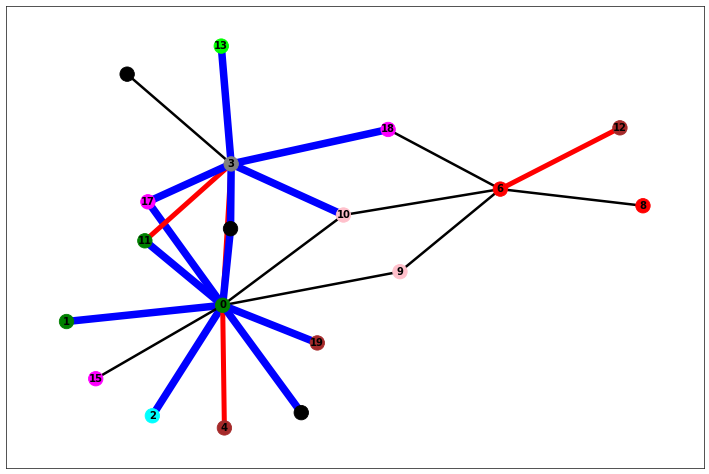

In [10]:
G = trainer[cls_idx].evaluate(threshold=0.5, show=True)

In [11]:
print(type(G))
print(G.adj)
print(G.nodes)
print(G.edges)

print('Nodes: ')
for v in list(G.nodes):
    print(G.nodes[v])

print('Edges: ')
for e in G.edges:
    print(G.edges[e])

<class 'networkx.classes.graph.Graph'>
{0: {1: {'label': 2}, 2: {'label': 2}, 3: {'label': 1}, 4: {'label': 1}, 9: {'label': 0}, 10: {'label': 0}, 11: {'label': 2}, 14: {'label': 2}, 15: {'label': 0}, 16: {'label': 2}, 17: {'label': 2}, 19: {'label': 2}}, 1: {0: {'label': 2}}, 2: {0: {'label': 2}}, 3: {0: {'label': 1}, 7: {'label': 0}, 10: {'label': 2}, 11: {'label': 1}, 13: {'label': 2}, 16: {'label': 2}, 17: {'label': 2}, 18: {'label': 2}}, 4: {0: {'label': 1}}, 9: {0: {'label': 0}, 6: {'label': 0}}, 10: {0: {'label': 0}, 3: {'label': 2}, 6: {'label': 0}}, 11: {0: {'label': 2}, 3: {'label': 1}}, 14: {0: {'label': 2}}, 15: {0: {'label': 0}}, 16: {0: {'label': 2}, 3: {'label': 2}}, 17: {0: {'label': 2}, 3: {'label': 2}}, 19: {0: {'label': 2}}, 7: {3: {'label': 0}}, 13: {3: {'label': 2}}, 18: {3: {'label': 2}, 6: {'label': 0}}, 6: {8: {'label': 0}, 9: {'label': 0}, 10: {'label': 0}, 12: {'label': 1}, 18: {'label': 0}}, 8: {6: {'label': 0}}, 12: {6: {'label': 1}}}
[0, 1, 2, 3, 4, 9, 10, 

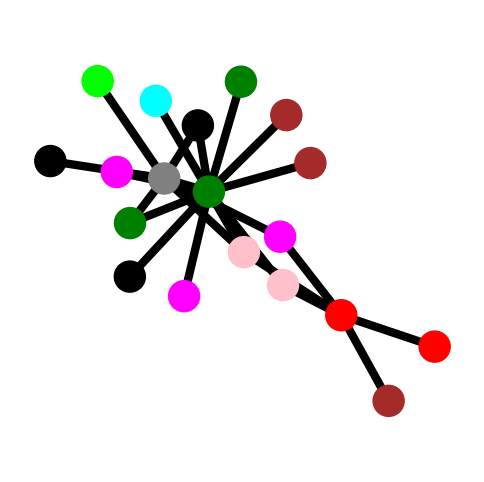

In [12]:
trainer[cls_idx].dataset.draw(G, ax=None)

# Non-Mutagen Class (Class 1)

In [13]:

cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        num_edge_cls=len(dataset.EDGE_CLS),
        seed=global_seed,
        temperature=0.15,
        learn_node_feat=True,
        learn_edge_feat=True,
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=4),
        dict(key="omega", criterion=NormPenalty(order=2), weight=4),
#         dict(key="xi", criterion=NormPenalty(order=1), weight=0),
#         dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=5),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=25, order=1, beta=1),
    seed=global_seed,
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)


In [14]:
trainer[cls_idx].train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  0%|          | 1/1000 [00:02<39:04,  2.35s/it, size=95.7, bpw=1.1, mutagen=-20.5, nonmutagen=19.1]

iteration=0, loss=3945.64, size=95.66069030761719, scores={'mutagen': -20.469196319580078, 'nonmutagen': 19.088808059692383}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  0%|          | 2/1000 [00:04<34:53,  2.10s/it, size=97.3, bpw=1.21, mutagen=-32.2, nonmutagen=29.5]

iteration=1, loss=37244.12, size=97.28115844726562, scores={'mutagen': -32.19041442871094, 'nonmutagen': 29.537221908569336}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  0%|          | 3/1000 [00:05<29:07,  1.75s/it, size=97.4, bpw=1.33, mutagen=-32.3, nonmutagen=29.3]

iteration=2, loss=35334.21, size=97.39328002929688, scores={'mutagen': -32.28684997558594, 'nonmutagen': 29.288042068481445}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  0%|          | 4/1000 [00:06<26:15,  1.58s/it, size=106, bpw=1.46, mutagen=-33.9, nonmutagen=30.2] 

iteration=3, loss=32977.73, size=106.4241714477539, scores={'mutagen': -33.864105224609375, 'nonmutagen': 30.15541648864746}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  0%|          | 5/1000 [00:08<24:41,  1.49s/it, size=102, bpw=1.61, mutagen=-31.6, nonmutagen=29.5]

iteration=4, loss=29065.69, size=102.47510528564453, scores={'mutagen': -31.571468353271484, 'nonmutagen': 29.45041275024414}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  1%|          | 6/1000 [00:09<23:45,  1.43s/it, size=94.3, bpw=1.77, mutagen=-37.7, nonmutagen=34.9]

iteration=5, loss=27919.05, size=94.29781341552734, scores={'mutagen': -37.67305374145508, 'nonmutagen': 34.86231231689453}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  1%|          | 7/1000 [00:10<23:00,  1.39s/it, size=97.8, bpw=1.95, mutagen=-37.8, nonmutagen=34]  

iteration=6, loss=28526.10, size=97.81202697753906, scores={'mutagen': -37.804622650146484, 'nonmutagen': 34.002342224121094}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  1%|          | 8/1000 [00:12<23:48,  1.44s/it, size=96.9, bpw=2.14, mutagen=-38.2, nonmutagen=35.8]

iteration=7, loss=27856.64, size=96.91326904296875, scores={'mutagen': -38.183616638183594, 'nonmutagen': 35.786033630371094}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  1%|          | 9/1000 [00:13<23:35,  1.43s/it, size=109, bpw=2.36, mutagen=-35.3, nonmutagen=32.4] 

iteration=8, loss=25172.48, size=108.95178985595703, scores={'mutagen': -35.30043029785156, 'nonmutagen': 32.35129165649414}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  1%|          | 10/1000 [00:15<23:08,  1.40s/it, size=104, bpw=2.59, mutagen=-35.5, nonmutagen=33.1]

iteration=9, loss=25613.55, size=103.82783508300781, scores={'mutagen': -35.541419982910156, 'nonmutagen': 33.09098434448242}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  1%|          | 11/1000 [00:16<23:08,  1.40s/it, size=105, bpw=2.85, mutagen=-34.1, nonmutagen=32.1]

iteration=10, loss=24339.13, size=105.11246490478516, scores={'mutagen': -34.09287643432617, 'nonmutagen': 32.14924621582031}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  1%|          | 12/1000 [00:17<22:35,  1.37s/it, size=96.9, bpw=3.14, mutagen=-34.5, nonmutagen=32.6]

iteration=11, loss=22987.97, size=96.92261505126953, scores={'mutagen': -34.53194808959961, 'nonmutagen': 32.56109619140625}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  1%|▏         | 13/1000 [00:19<22:50,  1.39s/it, size=102, bpw=3.45, mutagen=-32.2, nonmutagen=30.8] 

iteration=12, loss=21554.83, size=101.8106918334961, scores={'mutagen': -32.20708084106445, 'nonmutagen': 30.831653594970703}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  1%|▏         | 14/1000 [00:20<22:21,  1.36s/it, size=95.6, bpw=3.8, mutagen=-32.2, nonmutagen=30.9]

iteration=13, loss=21252.78, size=95.6338882446289, scores={'mutagen': -32.209922790527344, 'nonmutagen': 30.911996841430664}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  2%|▏         | 15/1000 [00:21<22:10,  1.35s/it, size=101, bpw=4.18, mutagen=-31.2, nonmutagen=30]  

iteration=14, loss=20454.41, size=100.5414047241211, scores={'mutagen': -31.1586971282959, 'nonmutagen': 29.96902847290039}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  2%|▏         | 16/1000 [00:23<24:07,  1.47s/it, size=101, bpw=4.59, mutagen=-32.7, nonmutagen=31.2]

iteration=15, loss=18574.33, size=101.3173599243164, scores={'mutagen': -32.67500305175781, 'nonmutagen': 31.175050735473633}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  2%|▏         | 17/1000 [00:25<23:22,  1.43s/it, size=98.9, bpw=5.05, mutagen=-32, nonmutagen=30.7] 

iteration=16, loss=18159.95, size=98.89887237548828, scores={'mutagen': -32.02273941040039, 'nonmutagen': 30.673107147216797}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  2%|▏         | 18/1000 [00:26<22:53,  1.40s/it, size=91.8, bpw=5.56, mutagen=-31.5, nonmutagen=30.3]

iteration=17, loss=17749.51, size=91.79148864746094, scores={'mutagen': -31.500471115112305, 'nonmutagen': 30.297298431396484}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  2%|▏         | 19/1000 [00:27<22:32,  1.38s/it, size=92.1, bpw=6.12, mutagen=-31.2, nonmutagen=29.8]

iteration=18, loss=17355.70, size=92.10587310791016, scores={'mutagen': -31.201915740966797, 'nonmutagen': 29.827072143554688}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  2%|▏         | 20/1000 [00:29<22:18,  1.37s/it, size=96.3, bpw=6.73, mutagen=-31, nonmutagen=29.7]  

iteration=19, loss=16833.31, size=96.28189086914062, scores={'mutagen': -31.02572250366211, 'nonmutagen': 29.692440032958984}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  2%|▏         | 21/1000 [00:30<22:00,  1.35s/it, size=93.1, bpw=7.4, mutagen=-30, nonmutagen=29.1] 

iteration=20, loss=16232.21, size=93.13069152832031, scores={'mutagen': -29.995101928710938, 'nonmutagen': 29.07362174987793}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  2%|▏         | 22/1000 [00:31<22:25,  1.38s/it, size=95.7, bpw=8.14, mutagen=-30.9, nonmutagen=29.6]

iteration=21, loss=15695.02, size=95.67189025878906, scores={'mutagen': -30.90965461730957, 'nonmutagen': 29.579994201660156}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  2%|▏         | 23/1000 [00:33<22:42,  1.39s/it, size=99.5, bpw=8.95, mutagen=-30.3, nonmutagen=29.2]

iteration=22, loss=15429.21, size=99.53170776367188, scores={'mutagen': -30.25372886657715, 'nonmutagen': 29.17453384399414}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  2%|▏         | 24/1000 [00:34<22:24,  1.38s/it, size=94.7, bpw=9.85, mutagen=-29.2, nonmutagen=28.3]

iteration=23, loss=15929.99, size=94.68572998046875, scores={'mutagen': -29.176868438720703, 'nonmutagen': 28.28316879272461}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  2%|▎         | 25/1000 [00:35<22:26,  1.38s/it, size=96.6, bpw=10.8, mutagen=-29.3, nonmutagen=28.2]

iteration=24, loss=15661.81, size=96.6203384399414, scores={'mutagen': -29.305702209472656, 'nonmutagen': 28.192636489868164}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  3%|▎         | 26/1000 [00:37<22:05,  1.36s/it, size=95.7, bpw=11.9, mutagen=-28.9, nonmutagen=28.2]

iteration=25, loss=16187.25, size=95.6993637084961, scores={'mutagen': -28.90740394592285, 'nonmutagen': 28.176044464111328}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  3%|▎         | 27/1000 [00:38<22:15,  1.37s/it, size=92.8, bpw=13.1, mutagen=-29.2, nonmutagen=28.3]

iteration=26, loss=16050.10, size=92.79603576660156, scores={'mutagen': -29.173398971557617, 'nonmutagen': 28.266942977905273}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  3%|▎         | 28/1000 [00:40<24:56,  1.54s/it, size=90.7, bpw=14.4, mutagen=-29.5, nonmutagen=28.6]

iteration=27, loss=15264.16, size=90.69316101074219, scores={'mutagen': -29.536096572875977, 'nonmutagen': 28.600603103637695}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  3%|▎         | 29/1000 [00:41<23:55,  1.48s/it, size=91.8, bpw=15.9, mutagen=-28.4, nonmutagen=27.6]

iteration=28, loss=15790.24, size=91.76105499267578, scores={'mutagen': -28.37303352355957, 'nonmutagen': 27.632587432861328}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  3%|▎         | 30/1000 [00:43<23:02,  1.43s/it, size=91.1, bpw=17.4, mutagen=-29, nonmutagen=28]    

iteration=29, loss=15441.84, size=91.13011169433594, scores={'mutagen': -29.044910430908203, 'nonmutagen': 28.0291690826416}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  3%|▎         | 31/1000 [00:44<22:21,  1.38s/it, size=90.7, bpw=19.2, mutagen=-32.1, nonmutagen=30.7]

iteration=30, loss=16597.67, size=90.72189331054688, scores={'mutagen': -32.05726623535156, 'nonmutagen': 30.743364334106445}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  3%|▎         | 32/1000 [00:45<21:54,  1.36s/it, size=82.1, bpw=21.1, mutagen=-29.4, nonmutagen=28.5]

iteration=31, loss=16905.96, size=82.0950927734375, scores={'mutagen': -29.44684410095215, 'nonmutagen': 28.482166290283203}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  3%|▎         | 33/1000 [00:47<21:34,  1.34s/it, size=87.1, bpw=23.2, mutagen=-29, nonmutagen=27.8]  

iteration=32, loss=18338.41, size=87.14330291748047, scores={'mutagen': -29.02444076538086, 'nonmutagen': 27.803693771362305}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  3%|▎         | 34/1000 [00:48<22:20,  1.39s/it, size=87.5, bpw=25.5, mutagen=-31.4, nonmutagen=29.8]

iteration=33, loss=19274.13, size=87.52861022949219, scores={'mutagen': -31.37590980529785, 'nonmutagen': 29.838546752929688}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  4%|▎         | 35/1000 [00:49<21:54,  1.36s/it, size=84.1, bpw=28.1, mutagen=-28.8, nonmutagen=27.8]

iteration=34, loss=19665.87, size=84.09362030029297, scores={'mutagen': -28.76819610595703, 'nonmutagen': 27.803255081176758}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  4%|▎         | 36/1000 [00:51<21:49,  1.36s/it, size=82.8, bpw=30.9, mutagen=-28.7, nonmutagen=28]  

iteration=35, loss=19935.34, size=82.84395599365234, scores={'mutagen': -28.692113876342773, 'nonmutagen': 27.990550994873047}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  4%|▎         | 37/1000 [00:52<21:32,  1.34s/it, size=83.4, bpw=34, mutagen=-28.9, nonmutagen=28]  

iteration=36, loss=19234.40, size=83.35453796386719, scores={'mutagen': -28.872142791748047, 'nonmutagen': 27.95108985900879}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  4%|▍         | 38/1000 [00:53<21:50,  1.36s/it, size=80.9, bpw=37.4, mutagen=-28.9, nonmutagen=27.9]

iteration=37, loss=18782.56, size=80.90825653076172, scores={'mutagen': -28.928638458251953, 'nonmutagen': 27.935686111450195}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  4%|▍         | 39/1000 [00:55<21:47,  1.36s/it, size=79.5, bpw=41.1, mutagen=-28.4, nonmutagen=27.4]

iteration=38, loss=18384.86, size=79.54153442382812, scores={'mutagen': -28.35569190979004, 'nonmutagen': 27.432971954345703}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  4%|▍         | 40/1000 [00:56<21:46,  1.36s/it, size=82.1, bpw=45.3, mutagen=-29.2, nonmutagen=28.2]

iteration=39, loss=17826.93, size=82.14671325683594, scores={'mutagen': -29.237327575683594, 'nonmutagen': 28.210878372192383}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  4%|▍         | 41/1000 [00:57<21:27,  1.34s/it, size=80.7, bpw=49.8, mutagen=-27.8, nonmutagen=27.1]

iteration=40, loss=17577.21, size=80.65498352050781, scores={'mutagen': -27.77471160888672, 'nonmutagen': 27.06582260131836}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  4%|▍         | 42/1000 [00:59<22:02,  1.38s/it, size=80.1, bpw=54.8, mutagen=-28.5, nonmutagen=27.6]

iteration=41, loss=17947.52, size=80.11431884765625, scores={'mutagen': -28.46629524230957, 'nonmutagen': 27.58381462097168}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  4%|▍         | 43/1000 [01:00<21:43,  1.36s/it, size=79.1, bpw=60.2, mutagen=-27.6, nonmutagen=26.9]

iteration=42, loss=17042.91, size=79.12116241455078, scores={'mutagen': -27.613203048706055, 'nonmutagen': 26.873489379882812}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  4%|▍         | 44/1000 [01:02<21:20,  1.34s/it, size=73.7, bpw=66.3, mutagen=-28.2, nonmutagen=27.4]

iteration=43, loss=16872.14, size=73.70787048339844, scores={'mutagen': -28.237585067749023, 'nonmutagen': 27.38710594177246}


  4%|▍         | 45/1000 [01:03<19:40,  1.24s/it, size=76.6, bpw=72.9, mutagen=-27.4, nonmutagen=26.6]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>
iteration=44, loss=17271.30, size=76.5582504272461, scores={'mutagen': -27.420852661132812, 'nonmutagen': 26.57540512084961}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  5%|▍         | 46/1000 [01:04<20:13,  1.27s/it, size=76.3, bpw=80.2, mutagen=-28.5, nonmutagen=27.6]

iteration=45, loss=18731.63, size=76.27987670898438, scores={'mutagen': -28.535903930664062, 'nonmutagen': 27.612051010131836}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  5%|▍         | 47/1000 [01:05<20:22,  1.28s/it, size=78.1, bpw=88.2, mutagen=-28, nonmutagen=27]    

iteration=46, loss=19138.04, size=78.06983947753906, scores={'mutagen': -28.005786895751953, 'nonmutagen': 27.007266998291016}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  5%|▍         | 48/1000 [01:06<20:22,  1.28s/it, size=80.4, bpw=97, mutagen=-28.3, nonmutagen=27.2]

iteration=47, loss=20277.60, size=80.35746002197266, scores={'mutagen': -28.341201782226562, 'nonmutagen': 27.2481689453125}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  5%|▍         | 49/1000 [01:08<20:49,  1.31s/it, size=79.4, bpw=107, mutagen=-27.8, nonmutagen=27] 

iteration=48, loss=19593.64, size=79.38081359863281, scores={'mutagen': -27.819744110107422, 'nonmutagen': 27.039592742919922}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  5%|▌         | 50/1000 [01:09<20:59,  1.33s/it, size=79.6, bpw=117, mutagen=-27.7, nonmutagen=27]

iteration=49, loss=20783.08, size=79.56776428222656, scores={'mutagen': -27.71007537841797, 'nonmutagen': 26.99569320678711}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  5%|▌         | 51/1000 [01:11<21:31,  1.36s/it, size=70.9, bpw=129, mutagen=-28.7, nonmutagen=28]

iteration=50, loss=22531.15, size=70.90605926513672, scores={'mutagen': -28.663070678710938, 'nonmutagen': 28.004064559936523}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  5%|▌         | 52/1000 [01:12<21:16,  1.35s/it, size=73.4, bpw=142, mutagen=-29.7, nonmutagen=28.5]

iteration=51, loss=23534.97, size=73.44425201416016, scores={'mutagen': -29.702877044677734, 'nonmutagen': 28.500885009765625}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  5%|▌         | 53/1000 [01:13<21:01,  1.33s/it, size=70.8, bpw=156, mutagen=-28.9, nonmutagen=27.9]

iteration=52, loss=25851.22, size=70.7982177734375, scores={'mutagen': -28.913623809814453, 'nonmutagen': 27.86139678955078}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  5%|▌         | 54/1000 [01:15<21:00,  1.33s/it, size=70.2, bpw=172, mutagen=-30.3, nonmutagen=29.1]

iteration=53, loss=26515.03, size=70.2225570678711, scores={'mutagen': -30.290910720825195, 'nonmutagen': 29.148719787597656}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  6%|▌         | 55/1000 [01:16<20:48,  1.32s/it, size=68.4, bpw=189, mutagen=-29.3, nonmutagen=28.1]

iteration=54, loss=25392.30, size=68.3695297241211, scores={'mutagen': -29.274959564208984, 'nonmutagen': 28.120716094970703}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  6%|▌         | 56/1000 [01:17<20:39,  1.31s/it, size=63.6, bpw=208, mutagen=-29.7, nonmutagen=28.3]

iteration=55, loss=25545.43, size=63.61219787597656, scores={'mutagen': -29.701093673706055, 'nonmutagen': 28.290462493896484}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  6%|▌         | 57/1000 [01:19<22:08,  1.41s/it, size=58.3, bpw=229, mutagen=-30.9, nonmutagen=29.5]

iteration=56, loss=24575.73, size=58.294795989990234, scores={'mutagen': -30.911094665527344, 'nonmutagen': 29.530942916870117}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  6%|▌         | 58/1000 [01:20<21:48,  1.39s/it, size=54.5, bpw=252, mutagen=-29.5, nonmutagen=28.4]

iteration=57, loss=25526.07, size=54.45808410644531, scores={'mutagen': -29.52383041381836, 'nonmutagen': 28.44843292236328}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  6%|▌         | 59/1000 [01:21<21:27,  1.37s/it, size=48.4, bpw=277, mutagen=-28, nonmutagen=26.4]  

iteration=58, loss=26179.88, size=48.44895935058594, scores={'mutagen': -27.972156524658203, 'nonmutagen': 26.4320011138916}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  6%|▌         | 60/1000 [01:23<21:17,  1.36s/it, size=47, bpw=304, mutagen=-29.9, nonmutagen=28.1]

iteration=59, loss=26453.54, size=46.96871566772461, scores={'mutagen': -29.880550384521484, 'nonmutagen': 28.09982681274414}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  6%|▌         | 61/1000 [01:24<21:51,  1.40s/it, size=36.8, bpw=335, mutagen=-28.8, nonmutagen=27.1]

iteration=60, loss=28253.62, size=36.81156921386719, scores={'mutagen': -28.801706314086914, 'nonmutagen': 27.118295669555664}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  6%|▌         | 62/1000 [01:26<21:55,  1.40s/it, size=32.1, bpw=368, mutagen=-27.7, nonmutagen=25.9]

iteration=61, loss=25771.05, size=32.143463134765625, scores={'mutagen': -27.72911262512207, 'nonmutagen': 25.87222671508789}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>


  6%|▋         | 63/1000 [01:27<21:43,  1.39s/it, size=28.3, bpw=405, mutagen=-30.1, nonmutagen=28.2]

iteration=62, loss=25328.36, size=28.314559936523438, scores={'mutagen': -30.099346160888672, 'nonmutagen': 28.22797393798828}

Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f497d40c310>


  6%|▋         | 64/1000 [01:28<21:19,  1.37s/it, size=21.2, bpw=446, mutagen=-22.5, nonmutagen=21.3]

iteration=63, loss=23027.34, size=21.230575561523438, scores={'mutagen': -22.48801040649414, 'nonmutagen': 21.285411834716797}


  6%|▋         | 64/1000 [01:29<21:56,  1.41s/it, size=21.2, bpw=446, mutagen=-22.5, nonmutagen=21.3]


Prediction of the sample:  <generator object Trainer.train.<locals>.<genexpr> at 0x7f4988daca90>
Expected number of edges of sample: 21.230575561523438; Budget: 25
Current explanation has high prediction probability and low expected maximum number of edges. Hence, it is a good explanation.
Breaking from train loop!



True

n=16 m=20
logits=[-26.415145874023438, 22.58234214782715]
probs=[5.256062324113925e-22, 1.0]
Graph Viz info: 
No of nodes:  16
Nodes:  [(0, {'label': 'Cl', 'color': 'green'}), (2, {'label': 'S', 'color': 'brown'}), (5, {'label': 'F', 'color': 'purple'}), (8, {'label': 'O', 'color': 'blue'}), (9, {'label': 'Br', 'color': 'pink'}), (10, {'label': 'Br', 'color': 'pink'}), (11, {'label': 'P', 'color': 'black'}), (12, {'label': 'Li', 'color': 'olive'}), (13, {'label': 'Ca', 'color': 'lime'}), (14, {'label': 'P', 'color': 'black'}), (15, {'label': 'N', 'color': 'orange'}), (19, {'label': 'Cl', 'color': 'green'}), (3, {'label': 'I', 'color': 'gray'}), (16, {'label': 'F', 'color': 'purple'}), (17, {'label': 'Li', 'color': 'olive'}), (7, {'label': 'F', 'color': 'purple'})]
No of edges:  20
Edges:  [(0, 2, {'label': 'triple', 'color': 'blue', 'width': 9}), (0, 5, {'label': 'single', 'color': 'black', 'width': 3}), (0, 8, {'label': 'double', 'color': 'red', 'width': 6}), (0, 9, {'label': 'single'

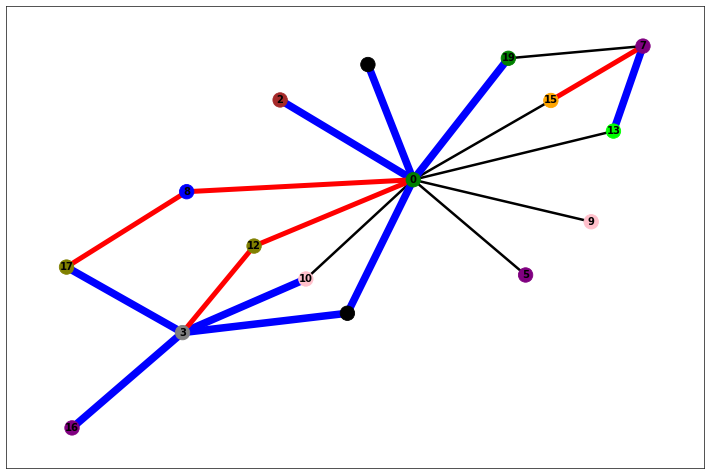

In [15]:
G = trainer[cls_idx].evaluate(threshold=0.5, show=True)

In [16]:
print(type(G))
print(G.adj)
print(G.nodes)
print(G.edges)

print('Nodes: ')
for v in list(G.nodes):
    print(G.nodes[v])
    
print('Edges: ')
for e in G.edges:
    print(G.edges[e])

<class 'networkx.classes.graph.Graph'>
{0: {2: {'label': 2}, 5: {'label': 0}, 8: {'label': 1}, 9: {'label': 0}, 10: {'label': 0}, 11: {'label': 2}, 12: {'label': 1}, 13: {'label': 0}, 14: {'label': 2}, 15: {'label': 0}, 19: {'label': 2}}, 2: {0: {'label': 2}}, 5: {0: {'label': 0}}, 8: {0: {'label': 1}, 17: {'label': 1}}, 9: {0: {'label': 0}}, 10: {0: {'label': 0}, 3: {'label': 2}}, 11: {0: {'label': 2}}, 12: {0: {'label': 1}, 3: {'label': 1}}, 13: {0: {'label': 0}, 7: {'label': 2}}, 14: {0: {'label': 2}, 3: {'label': 2}}, 15: {0: {'label': 0}, 7: {'label': 1}}, 19: {0: {'label': 2}, 7: {'label': 0}}, 3: {10: {'label': 2}, 12: {'label': 1}, 14: {'label': 2}, 16: {'label': 2}, 17: {'label': 2}}, 16: {3: {'label': 2}}, 17: {3: {'label': 2}, 8: {'label': 1}}, 7: {13: {'label': 2}, 15: {'label': 1}, 19: {'label': 0}}}
[0, 2, 5, 8, 9, 10, 11, 12, 13, 14, 15, 19, 3, 16, 17, 7]
[(0, 2), (0, 5), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 19), (8, 17), (10, 3), (12

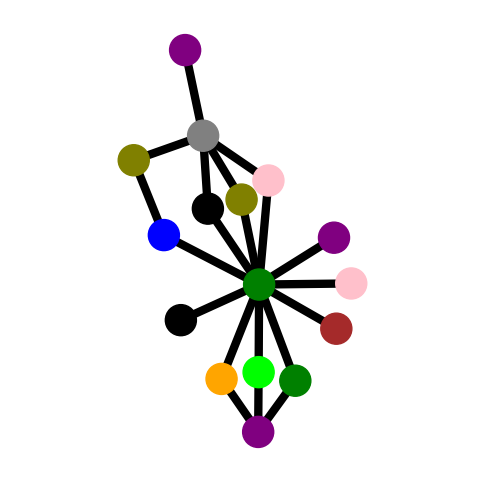

In [17]:
trainer[cls_idx].dataset.draw(G, ax=None)